In [2]:
# install package
!pip install pmdarima
 
# pmdarima 설치 후 런타임 재실행

     |████████████████████████████████| 1.5MB 10.5MB/s 
     |████████████████████████████████| 9.5MB 14.2MB/s 
     |████████████████████████████████| 2.1MB 33.4MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [1]:
# import lib
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pandas_datareader import data

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [50]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
# data = pd.read_csv('/Users/nageshsinghchauhan/Downloads/ML/time_series/stock-market/aaba.us.txt',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

'''
Sunrun inc - SUN
SolarEdge Technologies - SEDG  
Xinyi Solar holdings - 0968.HK
enphase energy - ENPH  
plug power - PLUG  
first solar - FSLR 
vestas wind systems - VWS.CO
Siemens Gamesa Renewable Energy - SGRE.MC 
Companhia Energetica de Minas Gerais - XCMIG.MC 
Boralex Inc. Class A - BLX
'''

start_date = '2019-10-31'
end_date   = '2020-10-31'

stock_code = 'ICLN'
stock_name = 'ICLN'

# 중화권은 25, 미국은 26
prior = 26

# Validation Data
valid_start_date = '2020-11-01'
valid_end_date   = '2020-12-07'
valid_stock_data = data.DataReader(stock_code,'yahoo', valid_start_date, valid_end_date).sort_index()

stock_data = data.DataReader(stock_code,'yahoo', start_date, end_date).sort_index()
stock_data.head(9)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-10-31,10.74,10.62,10.67,10.66,503000.0,10.536755
2019-11-01,10.74,10.69,10.70,10.70,259100.0,10.576293
2019-11-04,10.80,10.61,10.75,10.64,927300.0,10.516987
2019-11-05,10.63,10.54,10.61,10.63,248700.0,10.507102
2019-11-06,10.67,10.55,10.62,10.57,548500.0,10.447795
2019-11-07,10.67,10.54,10.64,10.55,524100.0,10.428027
2019-11-08,10.60,10.55,10.60,10.59,203300.0,10.467565
2019-11-11,10.70,10.60,10.63,10.70,153300.0,10.576293
2019-11-12,10.71,10.61,10.70,10.61,957300.0,10.487333


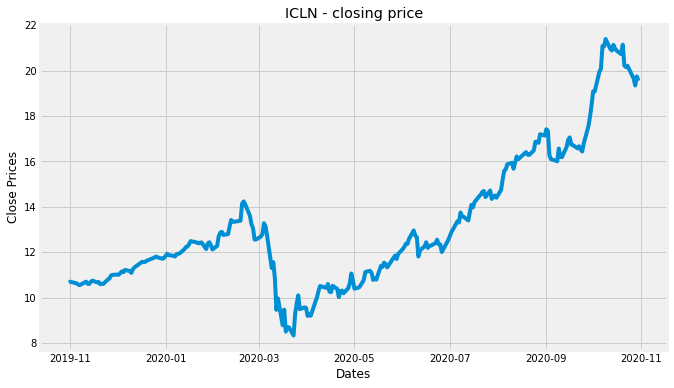

In [51]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title( stock_name + ' - closing price')
plt.show()

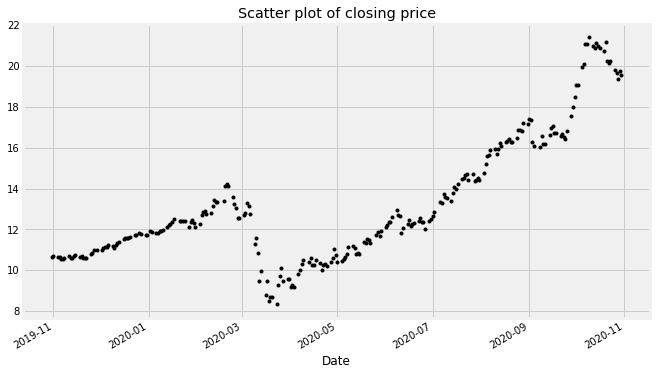

In [52]:
df_close = stock_data.copy()['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

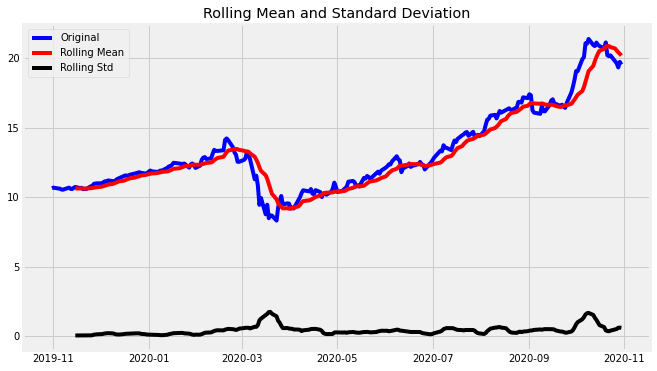

Results of dickey fuller test
Test Statistics                 -0.266349
p-value                          0.930137
No. of lags used                 7.000000
Number of observations used    245.000000
critical value (1%)             -3.457326
critical value (5%)             -2.873410
critical value (10%)            -2.573096
dtype: float64


In [53]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

<Figure size 720x432 with 0 Axes>

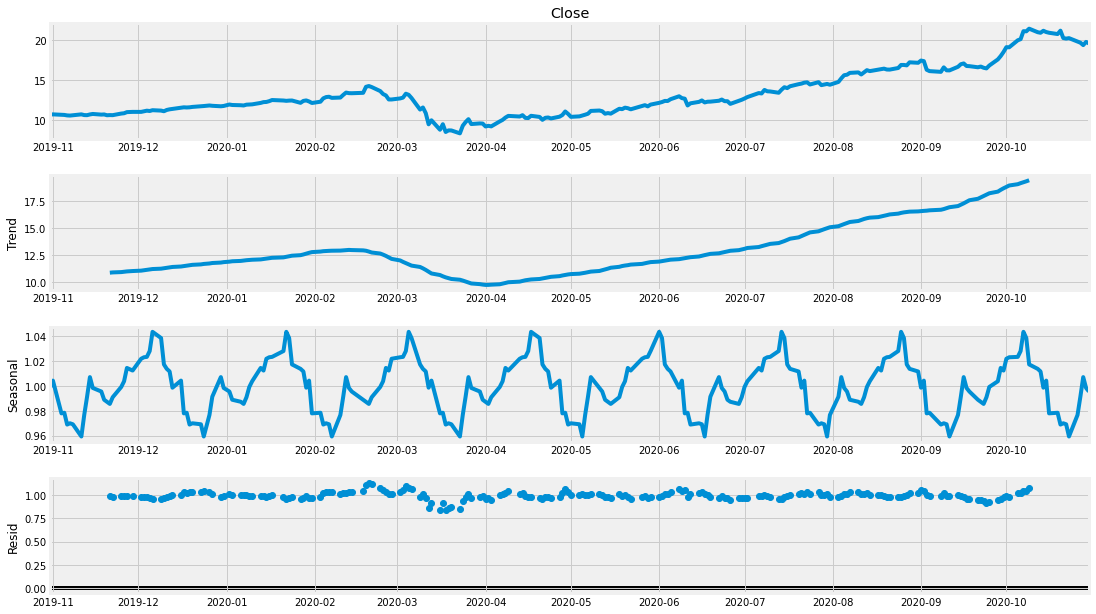

In [54]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

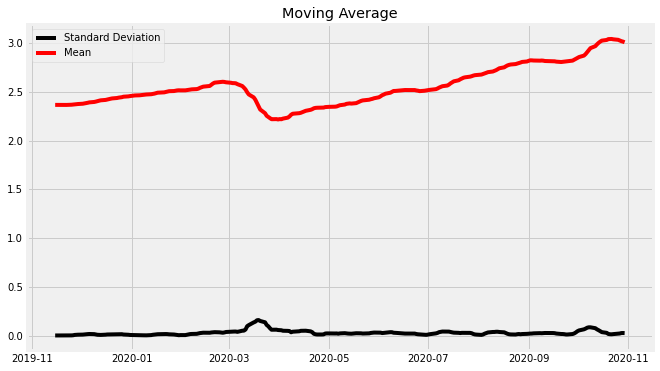

In [55]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

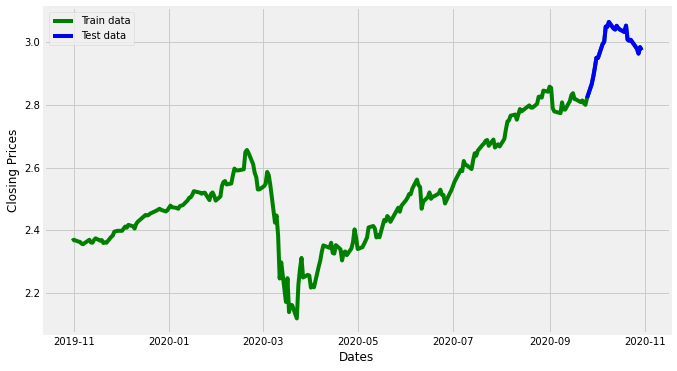

In [56]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [57]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-971.092, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-973.039, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-971.871, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-971.941, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-980.409, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-978.614, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-978.528, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-974.443, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-976.570, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-981.442, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-973.536, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-979.713, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-979.554, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-974.973, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]          

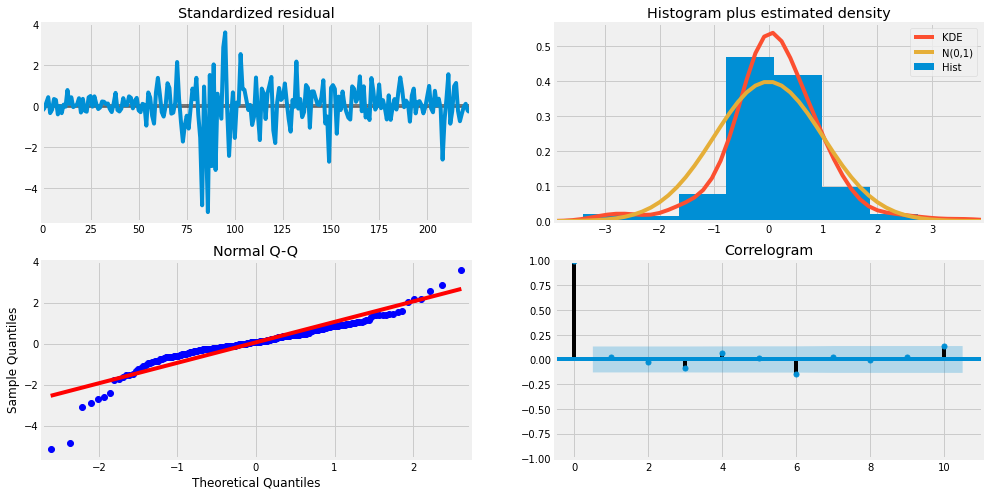

In [58]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [59]:
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 503.445
Method:                       css-mle   S.D. of innovations              0.025
Date:                Sat, 12 Dec 2020   AIC                           -992.890
Time:                        15:28:35   BIC                           -969.040
Sample:                             1   HQIC                          -983.262
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0019      0.002      1.023      0.306      -0.002       0.006
ar.L1.D.Close    -1.3858      0.135    -10.280      0.000      -1.650      -1.122
ar.L2.D.Close    -0.4175      0.192     

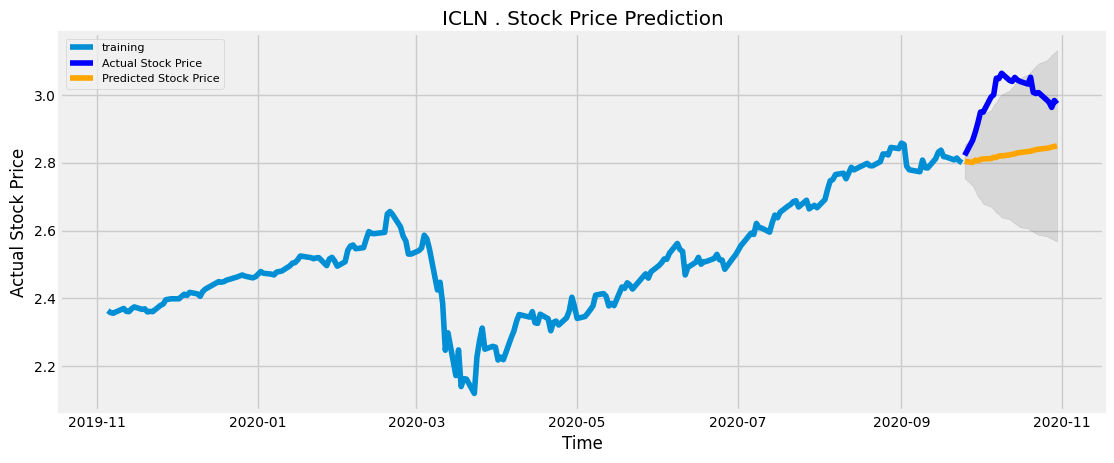

In [60]:
# Forecast
fc, se, conf = fitted.forecast(prior, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title(stock_name + ' . Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [61]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.030286155975527397
MAE: 0.16469583765716356
RMSE: 0.1740291813907294
MAPE: 0.05472137657325855


In [62]:
from fbprophet import Prophet
m = Prophet(daily_seasonality = True) # the Prophet class (model)

prophet_data = stock_data.copy().reset_index()
# m.fit(prophet_data) # fit the model using all data

# Select only the important features i.e. the date and price
prophet_data = prophet_data[["Date","Close"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
prophet_data = prophet_data.rename(columns = {"Date":"ds","Close":"y"}) #renaming the columns of the dataset

prophet_data

,ds,y
0,2019-10-31,10.660000
1,2019-11-01,10.700000
2,2019-11-04,10.640000
3,2019-11-05,10.630000
4,2019-11-06,10.570000
...,...,...
248,2020-10-26,19.799999
249,2020-10-27,19.650000
250,2020-10-28,19.350000
251,2020-10-29,19.750000


In [63]:
m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(prophet_data) # fit the model using all data

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [64]:
actual_data = stock_data.copy()
actual_data = actual_data['Close']

<Figure size 2000x600 with 0 Axes>

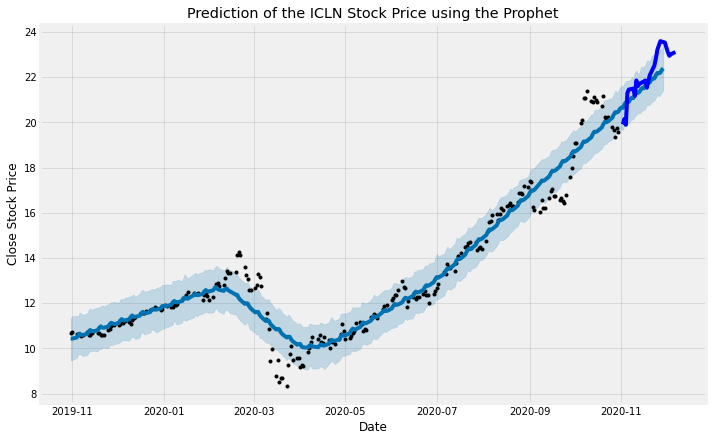

In [65]:
# 예측할 날짜
future_days = 30

future = m.make_future_dataframe(periods=future_days) #we need to specify the number of days in future
prediction = m.predict(future)

plt.figure(figsize=(20,6), dpi=100)
m.plot(prediction)



plt.plot(valid_stock_data["Close"], color = 'blue', label='Actual Stock Price')
plt.title("Prediction of the " +stock_name +" Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()